In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
import statsmodels
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
warnings.filterwarnings('ignore')
from itertools import combinations
import catboost as cb
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, auc, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc, confusion_matrix 
from sklearn.metrics import f1_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier
import xgboost
import pylab as pl

In [2]:
data_W = pd.read_csv('Workflow_dataset.csv')
data_W.shape

(32000, 231)

In [3]:
data_W.head(2)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,churn
0,NaN,NaN,NaN,NaN,NaN,770.0,7.0,NaN,NaN,NaN,...,jCiQv5o,NaN,NaN,NaN,kwS7,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,399.0,0.0,NaN,NaN,NaN,...,CFMqCcD,LM8l689qOp,NaN,NaN,Qcbd,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


In [4]:
def data_to_xy(df):
    x = df.iloc[:,0:-1]  # датасет с признаками
    y = pd.DataFrame(df.iloc[:,-1], columns = ['churn'])  # датасет с классами
    y.loc[y.churn == -1] = 0
    return x, y

def split_num_cat(df):
    '''Делит датасет на числовые и категориальные признаки'''
    df_num = df.iloc[:,0:190]
    df_cat = df.iloc[:,190:]
    return df_num, df_cat

def drop_nans(df, df_test):
    '''Удаляет пустые колонки из тренировочного датасета.
    Те же самое колонки удаляются и в тренировочном датасете.
    Не исключаетс варианта, что в тренировочной выборке останутся пустые колонки'''
    cols_to_save = df.columns[df.isna().sum() != len(df)]
    return df[cols_to_save], df_test[cols_to_save]

def fill_nans (df, df_test, method):
    '''Заполняет пропуски в данных'''
    imputer = SimpleImputer(missing_values=np.nan, strategy=method).fit(df)
    df_ = pd.DataFrame(imputer.transform(df), columns = df.columns)
    df_test_t = pd.DataFrame(imputer.transform(df_test[df_.columns]), columns = df_test.columns)
    return df_, df_test_t

def num_to_cat(df_n, df_t_n, df_c, df_t_c):
    '''Если уникальных значений в числовых признаках меньше 20, то приравниваем его к категориальному.'''
    num_cols = []  # Колонки для числовых признаков
    cat_cols = []  # Колонки для категориальных признаков
    for i in df_n.columns:
        if len(df_n[i].value_counts()) < 20:
            df_c = pd.concat([df_c, df_n[i]], axis = 1)
            df_t_c = pd.concat([df_t_c, df_t_n[i]], axis = 1)
        else:
            num_cols.append(i)
    return df_n[num_cols], df_t_n[num_cols], df_c, df_t_c   
            

def freq_encode (df, df_test):
    '''Частотное кодирование категориальных данных.
    Незатронутые значения в обучающей будут заменены на нули'''
    for i in df.columns:
        df_mask = df.groupby(i).size()/len(df)
        df[i] = df[i].map(df_mask)
        df_test[i] = df_test[i].map(df_mask)
        df_test = df_test.fillna(0)
    return df, df_test

def concat(df_num, df_cat):
    return pd.DataFrame(pd.concat([df_num, df_cat], axis = 1))

def oversample(x, y):
    ros = RandomOverSampler(random_state=0, sampling_strategy = 1)
    x, y = ros.fit_resample(x, y)
    return x, y

In [5]:
# Делим данные на треин и лейблы
X, y = data_to_xy(data_W)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [6]:
# Делим данные на категоралиальные и вещественные признаки
X_num, X_cat = split_num_cat(X)
X_test_num, X_test_cat = split_num_cat(X_test)

In [7]:
# Удаляем полностью пустые признаки в данных
X_num, X_test_num = drop_nans(X_num, X_test_num)
X_cat, X_test_cat = drop_nans(X_cat, X_test_cat)
print('Количество вещественных признаков: ', X_num.shape[1], X_test_num.shape[1])
print('Количество категориальных признаков: ', X_cat.shape[1], X_test_cat.shape[1])

Количество вещественных признаков:  174 174
Количество категориальных признаков:  38 38


In [8]:
# !!!! NUM TO CAT
X_num, X_test_num, X_cat, X_test_cat = num_to_cat(X_num, X_test_num, X_cat, X_test_cat)
print('Размерность обучающей выборки: ', X_num.shape, X_cat.shape)
print('Размерность тренировочной выборки:', X_test_num.shape, X_test_cat.shape)

Размерность обучающей выборки:  (32000, 116) (32000, 96)
Размерность тренировочной выборки: (8000, 116) (8000, 96)


In [9]:
# Выбираем методы заполнения пропусков:
# Вещественные признаках: среднее
# Категориальные: 'missing_value'
X_num, X_test_num = fill_nans(X_num, X_test_num, 'mean')
X_cat, X_test_cat = fill_nans(X_cat, X_test_cat, 'constant')

In [10]:
X_cat, X_test_cat = freq_encode(X_cat, X_test_cat)

In [11]:
X_train = concat(X_num, X_cat)
X_test = concat(X_test_num, X_test_cat)

In [12]:
print(X_train.shape, X_test.shape)

(32000, 212) (8000, 212)


### Построение моделей

In [13]:
model_dict = {'sgb' :  GradientBoostingClassifier(), 
              'log' : LogisticRegression(), 
              'catboost' : CatBoostClassifier(silent=True), 
              'xgboost' : xgboost.XGBClassifier()
             }

In [14]:
# добавим oversampling
X_train, y = oversample(X_train, y)

In [15]:
y.shape

(59238, 1)

In [16]:
def calculate_me (model, X_tr, X_t, y_tr, y_t):
    pl.clf()
    plt.figure(figsize=(6,6))
    est = model_dict[model]
    fitted = est.fit(X_tr, y_tr)
    probas = fitted.predict_proba(X_t)
    fpr, tpr, thresholds = roc_curve(y_t, probas[:, 1])
    roc_auc  = auc(fpr, tpr)
    pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (model, roc_auc))
    y_pred = pd.DataFrame(est.predict(X_t), columns = ['DF'])
    y_pred_vals = y_pred['DF'].value_counts()
    conf_matrix = confusion_matrix(y_t, y_pred).ravel()
    print(pd.DataFrame(conf_matrix).rename({0: 'TN', 1: 'FP', 2: 'FN', 3: 'TP'}))
    print('Precision score: ', round(precision_score(y_t, y_pred), 4))
    print('Recall score: ', round(recall_score(y_t, y_pred), 4))
    print('F1 score = ',round(f1_score(y_t, y_pred), 4))    
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.title(model + ' classifier')
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.legend(loc=0, fontsize='small')
    pl.show()

In [17]:
print(cross_val_score(model_dict['sgb'], X_train, y, cv=5))

[0.71682984 0.71818028 0.71370695 0.71165696 0.71216342]


       0
TN  5185
FP  2220
FN   138
TP   457
Precision score:  0.1707
Recall score:  0.7681
F1 score =  0.2793


<Figure size 432x288 with 0 Axes>

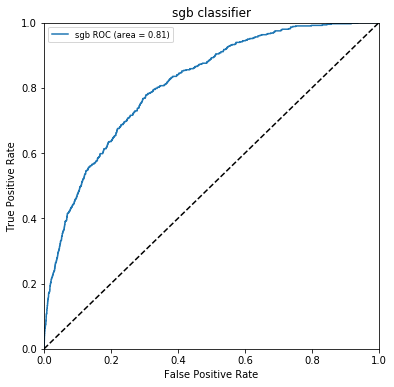

In [18]:
calculate_me('sgb' ,X_train, X_test, y, y_test)

In [19]:
print(cross_val_score(model_dict['xgboost'], X_train, y, cv=5))

[0.70864281 0.71666104 0.71252532 0.70853381 0.71123491]


       0
TN  5172
FP  2233
FN   145
TP   450
Precision score:  0.1677
Recall score:  0.7563
F1 score =  0.2746


<Figure size 432x288 with 0 Axes>

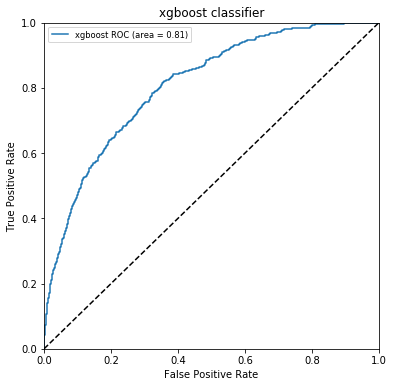

In [20]:
calculate_me('xgboost',X_train, X_test, y, y_test)

In [21]:
print(cross_val_score(model_dict['log'], X_train, y, cv=5))

[0.54827819 0.55064146 0.5487846  0.54942179 0.55271377]


       0
TN  3514
FP  3891
FN   244
TP   351
Precision score:  0.0827
Recall score:  0.5899
F1 score =  0.1451


<Figure size 432x288 with 0 Axes>

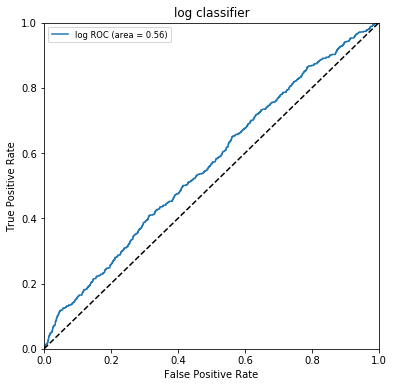

In [22]:
calculate_me('log',X_train, X_test, y, y_test)

#### Вывод: 
1. Логистическая регрессия выступила не очень выразительно, что логично, ведь данные готовились для градиентного бустинга.
2. XGboost и sgb показали идентичные резельтаты.

Применение кроссвалидации не очень уместно, потому что без пайплайна данные при кодировании "утекают" в тест, из-за этого получаются завышенные оценки.